# import stuff

In [1]:
import sys, os
sys.path.append(os.path.realpath(".."))

import util_funcs
from importlib import reload
reload(util_funcs)
from copy import deepcopy as cp

import data_reader as read
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import pywt
import tsfresh.feature_extraction.feature_calculators as feats
import constants
import clinical_text_analysis as cta
reload(cta)
import tsfresh
import ensembleReader as er
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, r2_score, classification_report
from os import path

reload(read)
import wf_analysis.datasets as wfdata
import wf_analysis.filters as filt
reload(filt)
from addict import Dict
import time
import pickle as pkl
import tsfresh.feature_extraction.feature_calculators as tsf
import pyedflib as edf
import keras_models.dataGen as dg 

Using Theano backend.


## Pull in data

In [2]:
train_edss = pkl.load(open("/n/scratch2/ms994/train_multiple_labels_sessions_seizure_data_4.pkl", "rb"))

In [3]:
train_seizure_labels = [datum[1][0] for datum in train_edss]
train_session_labels = [datum[1][1] for datum in train_edss]
train_subtype_labels = [datum[1][2] for datum in train_edss]

In [4]:
train_edg = dg.EdfDataGenerator(train_edss, precache=True, labels=train_seizure_labels, shuffle=False, batch_size=512, n_classes=2)

In [5]:
valid_edss = pkl.load(open("/n/scratch2/ms994/valid_multiple_labels_sessions_seizure_data_4.pkl", "rb"))

In [6]:
valid_seizure_labels = [datum[1][0] for datum in valid_edss]
valid_session_labels = [datum[1][1] for datum in valid_edss]
valid_subtype_labels = [datum[1][2] for datum in valid_edss]

In [7]:
valid_edg = dg.EdfDataGenerator(valid_edss, precache=True, labels=valid_seizure_labels, shuffle=False, batch_size=512)

In [8]:
from keras.models import load_model

In [9]:
model = load_model("/n/scratch2/ms994/out/UMEPVXFQHNWCHTKS.h5")

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1000, 21, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1000, 21, 4)  20          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 500, 21, 4)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 500, 21, 4)   16          max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
conv2d_2 (

# Predict train and try to correlate that with different metrics we see in the data it predicts from

## predict here (exp 6538)

In [11]:
pred = model.predict_generator(train_edg)

In [12]:
val_pred = model.predict_generator(valid_edg)

In [13]:
from addict import Dict

In [14]:
cachedAnalysisResults = Dict()

In [15]:
cachedAnalysisResults.trainMaxPerSegment = [datum[0].max() for datum in train_edss]
cachedAnalysisResults.trainMinPerSegment = [datum[0].min() for datum in train_edss]
cachedAnalysisResults.trainStdPerSegment = [datum[0].std() for datum in train_edss]
cachedAnalysisResults.trainMeanPerSegment = [datum[0].mean() for datum in train_edss]

cachedAnalysisResults.validMaxPerSegment = [datum[0].max() for datum in valid_edss]
cachedAnalysisResults.validMinPerSegment = [datum[0].min() for datum in valid_edss]
cachedAnalysisResults.validStdPerSegment = [datum[0].std() for datum in valid_edss]
cachedAnalysisResults.validMeanPerSegment = [datum[0].mean() for datum in valid_edss]

In [16]:
cachedAnalysisResults.train_seizure_labels = train_seizure_labels
cachedAnalysisResults.train_session_labels = train_session_labels
cachedAnalysisResults.train_subtype_labels = train_subtype_labels


In [17]:
cachedAnalysisResults.valid_seizure_labels = valid_seizure_labels
cachedAnalysisResults.valid_session_labels = valid_session_labels
cachedAnalysisResults.valid_subtype_labels = valid_subtype_labels


In [18]:
cachedAnalysisResults.pred = pred
cachedAnalysisResults.val_pred = val_pred

In [33]:
def save_cached():
    global cachedAnalysisResults
    pkl.dump(cachedAnalysisResults, open("/n/scratch2/ms994/exp6538Analysis.pkl", "wb"))

In [44]:
save_cached()

In [2]:
cachedAnalysisResults = pkl.load(open("/n/scratch2/ms994/exp6538Analysis.pkl", "rb"))

In [3]:
cachedAnalysisResults.keys()

dict_keys(['trainMaxPerSegment', 'trainMinPerSegment', 'trainStdPerSegment', 'trainMeanPerSegment', 'validMaxPerSegment', 'validMinPerSegment', 'validStdPerSegment', 'validMeanPerSegment', 'train_seizure_labels', 'train_session_labels', 'train_subtype_labels', 'valid_seizure_labels', 'valid_session_labels', 'valid_subtype_labels', 'pred', 'val_pred'])

In [22]:
seizDetectPred = cachedAnalysisResults.pred[0].argmax(1)

In [23]:
print(classification_report(seizDetectPred, train_seizure_labels, output_dict=False))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96    108175
           1       0.89      0.75      0.81     24608

    accuracy                           0.94    132783
   macro avg       0.92      0.86      0.89    132783
weighted avg       0.93      0.94      0.93    132783



## see the error rate per session

In [24]:
train_pred_errors_per_session = pd.Series(train_session_labels)[train_seizure_labels!=pred[0].argmax(1)].value_counts()
train_false_alarms_per_session = pd.Series(train_session_labels)[(train_seizure_labels!=pred[0].argmax(1)) & (np.array(train_seizure_labels) == False)].value_counts()
train_missed_seizures_per_session = pd.Series(train_session_labels)[(train_seizure_labels!=pred[0].argmax(1)) & (np.array(train_seizure_labels) == True)].value_counts()

In [28]:
train_fail_per_session_rate = (pd.Series(train_session_labels)[train_seizure_labels!=pred[0].argmax(1)].value_counts()/pd.Series(train_session_labels).value_counts()).sort_values(ascending=False).fillna(0)
train_false_alarms_per_session_rate = (pd.Series(train_session_labels)[train_seizure_labels!=pred[0].argmax(1) & (np.array(train_seizure_labels) == False)].value_counts()/pd.Series(train_session_labels).value_counts()).sort_values(ascending=False).fillna(0)
train_missed_seizures_per_session_rate = (pd.Series(train_session_labels)[train_seizure_labels!=pred[0].argmax(1) & (np.array(train_seizure_labels) == True)].value_counts()/pd.Series(train_session_labels).value_counts()).sort_values(ascending=False).fillna(0)

In [31]:
valid_pred_errors_per_session = pd.Series(valid_session_labels)[valid_seizure_labels!=val_pred[0].argmax(1)].value_counts()
valid_false_alarms_per_session = pd.Series(valid_session_labels)[(valid_seizure_labels!=val_pred[0].argmax(1)) & (np.array(valid_seizure_labels) == False)].value_counts()
valid_missed_seizures_per_session = pd.Series(valid_session_labels)[(valid_seizure_labels!=val_pred[0].argmax(1)) & (np.array(valid_seizure_labels) == True)].value_counts()

In [32]:
valid_fail_per_session_rate = (pd.Series(valid_session_labels)[valid_seizure_labels!=val_pred[0].argmax(1)].value_counts()/pd.Series(valid_session_labels).value_counts()).sort_values(ascending=False).fillna(0)
valid_false_alarms_per_session_rate = (pd.Series(valid_session_labels)[valid_seizure_labels!=val_pred[0].argmax(1) & (np.array(valid_seizure_labels) == False)].value_counts()/pd.Series(valid_session_labels).value_counts()).sort_values(ascending=False).fillna(0)
valid_missed_seizures_per_session_rate = (pd.Series(valid_session_labels)[valid_seizure_labels!=val_pred[0].argmax(1) & (np.array(valid_seizure_labels) == True)].value_counts()/pd.Series(valid_session_labels).value_counts()).sort_values(ascending=False).fillna(0)

### Compare to seizure rate per session

In [90]:
bins_fail = [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]
seizure_label_bins = []
for i in range(len(bins_fail)-1):
    sliced_sessions = (valid_fail_per_session_rate > bins_fail[i]) & (valid_fail_per_session_rate < bins_fail[i+1])
    
#     seizure_label_bins.append(sliced_sessions)

    seizure_label_bins.append(pd.Series(valid_seizure_labels)[pd.Series(valid_session_labels).apply(lambda session_label: sliced_sessions[session_label])])

In [59]:
len([seizure_label_bins[i].sum()/seizure_label_bins[i].shape[0] for i in range(len(seizure_label_bins))])

10

In [85]:
import matplotlib.colors as mcolors
import numpy as np

clist = [(0, "red"), (1, "blue")]
rvb = mcolors.LinearSegmentedColormap.from_list("", clist)

N = 60
x = np.arange(N).astype(float)
y = np.random.uniform(0, 5, size=(N,))

/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':


Text(0, 0.5, 'Seizure Rate for Each Session')

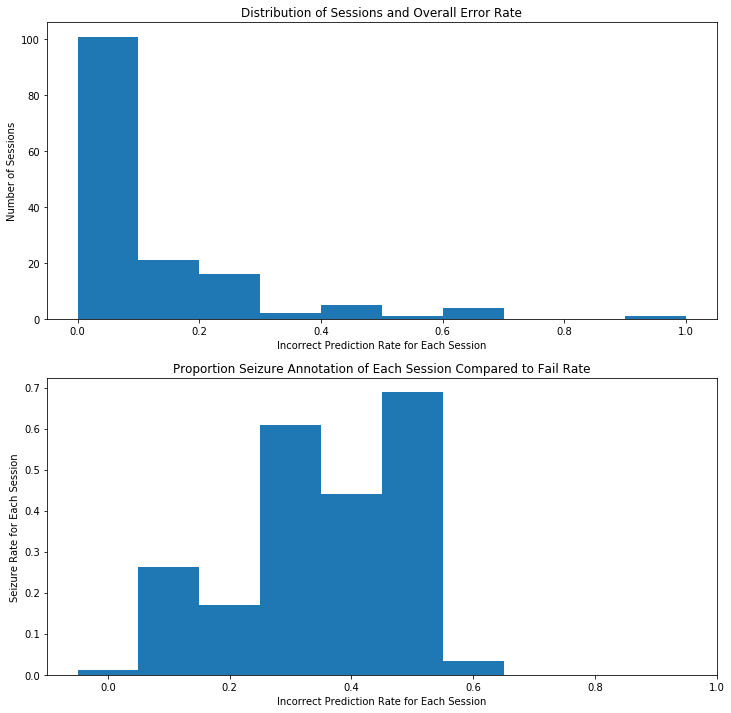

In [91]:
figure = plt.figure(figsize=(12,12))
ax = plt.subplot(2, 1, 1)
ax.set_title( "Distribution of Sessions and Overall Error Rate")

ax.set_xlabel("Incorrect Prediction Rate for Each Session")
ax.set_ylabel("Number of Sessions")
histogram = plt.hist(valid_fail_per_session_rate)



ax = plt.subplot(2, 1, 2)
plt.bar(height=pd.Series([seizure_label_bins[i].sum()/seizure_label_bins[i].shape[0] for i in range(len(seizure_label_bins))]).fillna(0), x=[0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,], width=0.1)
ax.set_title("Proportion Seizure Annotation of Each Session Compared to Fail Rate")
ax.set_xlabel("Incorrect Prediction Rate for Each Session")
ax.set_ylabel("Seizure Rate for Each Session")

In [75]:
bins_fail = [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]
seizure_label_bins = []
for i in range(len(bins_fail)-1):
    sliced_sessions = (train_fail_per_session_rate > bins_fail[i]) & (train_fail_per_session_rate < bins_fail[i+1])
#     seizure_label_bins.append(sliced_sessions)

    seizure_label_bins.append(pd.Series(train_seizure_labels)[pd.Series(train_session_labels).apply(lambda session_label: sliced_sessions[session_label])])

/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':


Text(0, 0.5, 'Seizure Rate for Each Session')

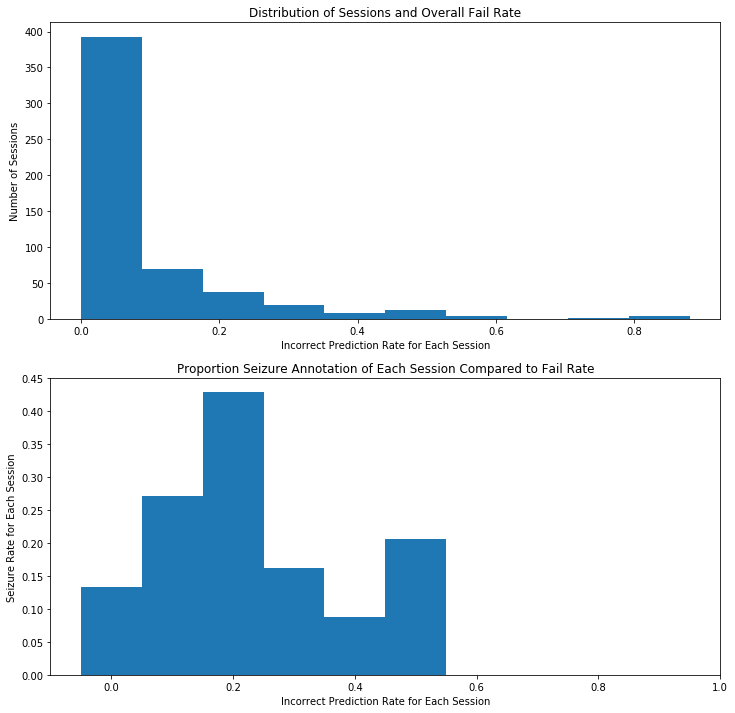

In [79]:
figure = plt.figure(figsize=(12,12))
ax = plt.subplot(2, 1, 1)
ax.set_title( "Distribution of Sessions and Overall Fail Rate")

ax.set_xlabel("Incorrect Prediction Rate for Each Session")
ax.set_ylabel("Number of Sessions")
histogram = plt.hist(train_fail_per_session_rate)



ax = plt.subplot(2, 1, 2)
plt.bar(height=pd.Series([seizure_label_bins[i].sum()/seizure_label_bins[i].shape[0] for i in range(len(seizure_label_bins))]).fillna(0), x=[0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,], width=0.1)
ax.set_title("Proportion Seizure Annotation of Each Session Compared to Fail Rate")
ax.set_xlabel("Incorrect Prediction Rate for Each Session")
ax.set_ylabel("Seizure Rate for Each Session")

/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


Text(0, 0.5, 'Seizure Rate for Each Session')

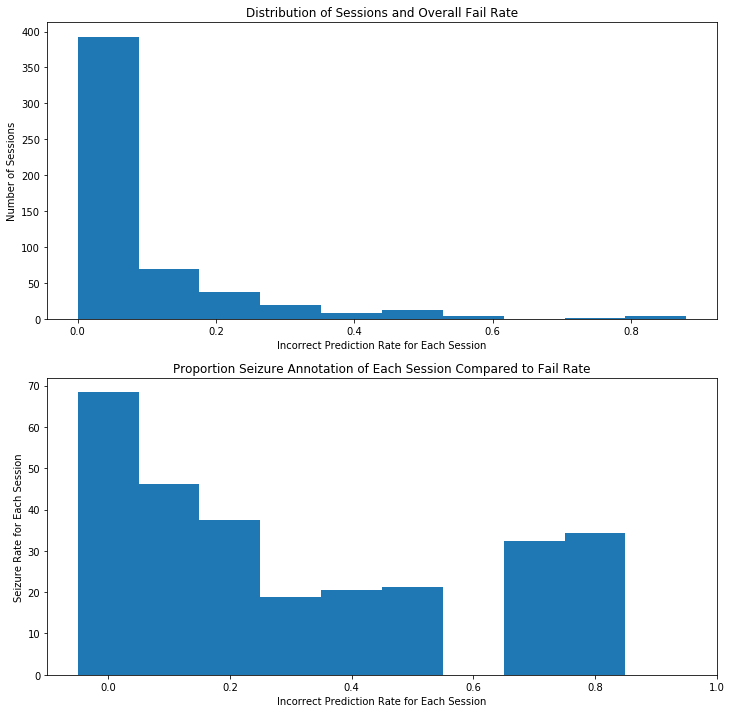

In [93]:
bins_fail = [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]
seizure_label_bins = []
for i in range(len(bins_fail)-1):
    sliced_sessions = (train_fail_per_session_rate > bins_fail[i]) & (train_fail_per_session_rate < bins_fail[i+1])
#     seizure_label_bins.append(sliced_sessions)

    seizure_label_bins.append(pd.Series(cachedAnalysisResults.trainStdPerSegment)[pd.Series(train_session_labels).apply(lambda session_label: sliced_sessions[session_label])])
    
figure = plt.figure(figsize=(12,12))
ax = plt.subplot(2, 1, 1)
ax.set_title( "Distribution of Sessions and Overall Fail Rate")

ax.set_xlabel("Incorrect Prediction Rate for Each Session")
ax.set_ylabel("Number of Sessions")
histogram = plt.hist(train_fail_per_session_rate)



ax = plt.subplot(2, 1, 2)
plt.bar(height=pd.Series([seizure_label_bins[i].sum()/seizure_label_bins[i].shape[0] for i in range(len(seizure_label_bins))]).fillna(0), x=[0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,], width=0.1)
ax.set_title("Proportion Seizure Annotation of Each Session Compared to Fail Rate")
ax.set_xlabel("Incorrect Prediction Rate for Each Session")
ax.set_ylabel("Seizure Rate for Each Session")

/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


Text(0, 0.5, 'Seizure Rate for Each Session')

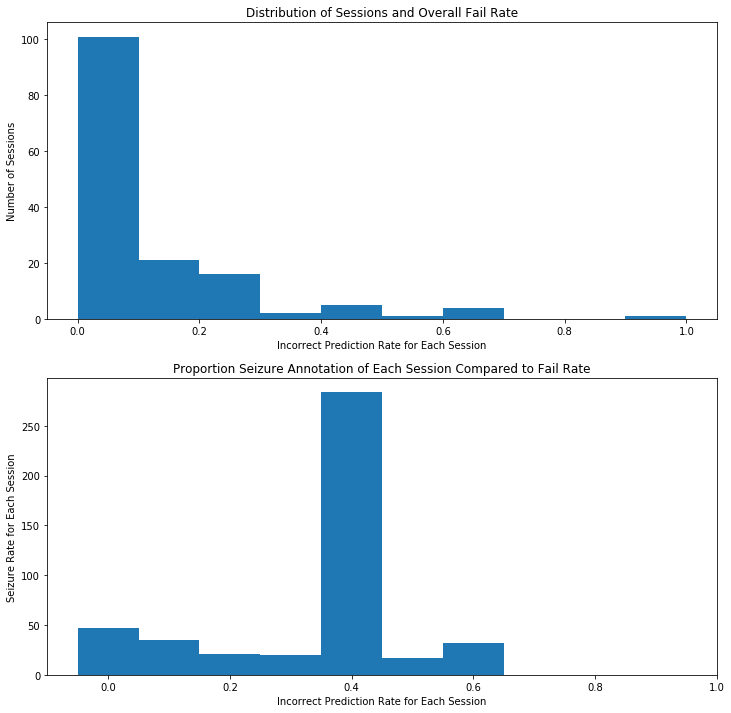

In [94]:
bins_fail = [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]
seizure_label_bins = []
for i in range(len(bins_fail)-1):
    sliced_sessions = (valid_fail_per_session_rate > bins_fail[i]) & (valid_fail_per_session_rate < bins_fail[i+1])
#     seizure_label_bins.append(sliced_sessions)

    seizure_label_bins.append(pd.Series(cachedAnalysisResults.validStdPerSegment)[pd.Series(valid_session_labels).apply(lambda session_label: sliced_sessions[session_label])])
    
figure = plt.figure(figsize=(12,12))
ax = plt.subplot(2, 1, 1)
ax.set_title( "Distribution of Sessions and Overall Fail Rate")

ax.set_xlabel("Incorrect Prediction Rate for Each Session")
ax.set_ylabel("Number of Sessions")
histogram = plt.hist(valid_fail_per_session_rate)



ax = plt.subplot(2, 1, 2)
plt.bar(height=pd.Series([seizure_label_bins[i].sum()/seizure_label_bins[i].shape[0] for i in range(len(seizure_label_bins))]).fillna(0), x=[0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,], width=0.1)
ax.set_title("Proportion Seizure Annotation of Each Session Compared to Fail Rate")
ax.set_xlabel("Incorrect Prediction Rate for Each Session")
ax.set_ylabel("Seizure Rate for Each Session")

(array([15763., 12698.,  4486.,  1278.,   610.,   450.,   412.,   324.,
          220.,   184.,   287.,   165.,   111.,    70.,    79.,    86.,
          146.,    69.,    51.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170, 180, 190]),
 <a list of 19 Patch objects>)

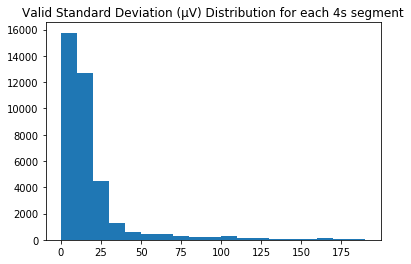

In [99]:
plt.title("Valid Standard Deviation (µV) Distribution for each 4s segment")
plt.hist(cachedAnalysisResults.validStdPerSegment, bins=[10*i for i in range(20)])

(array([41511., 50780., 15659.,  5093.,  2120.,  1394.,  1363.,  1483.,
         1075.,   616.,   610.,   623.,   358.,   474.,   628.,   365.,
          433.,   254.,   238.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170, 180, 190]),
 <a list of 19 Patch objects>)

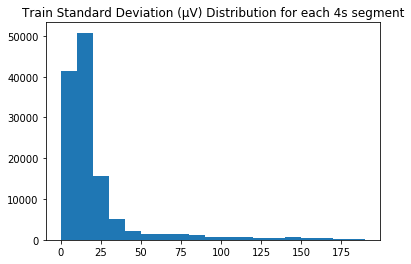

In [100]:
plt.title("Train Standard Deviation (µV) Distribution for each 4s segment")
plt.hist(cachedAnalysisResults.trainStdPerSegment, bins=[10*i for i in range(20)])

In [9]:
full_df = pd.DataFrame([cachedAnalysisResults.trainStdPerSegment, cachedAnalysisResults.train_seizure_labels, cachedAnalysisResults.train_session_labels], index=["std", "seiz", "sess"]).T

In [28]:
full_df["std"] = full_df["std"].astype(np.float)

In [31]:
sbs = pd.DataFrame([full_df.groupby("sess")["std"].mean(), full_df.groupby("sess")["seiz"].sum()/full_df.groupby("sess")["seiz"].count()]).T

In [33]:
sbs

,std,seiz
sess,,
00000077/s003_2010_01_21,29.194767,0.000000
00000254/s005_2010_11_15,6.273648,0.000000
00000254/s006_2011_07_01,5.377775,0.000000
00000254/s007_2013_03_25,26.027723,0.000000
00000458/s005_2003_02_12,23.536660,0.000000
00000458/s011_2014_06_24,15.545072,0.000000
00000458/s012_2014_06_25,19.902327,0.000000
00000492/s003_2003_07_18,17.604735,0.187935
00000529/s004_2012_06_05,9.701745,0.000000


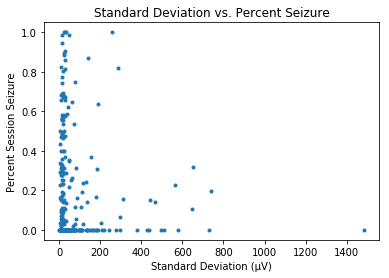

In [40]:
plt.title("Standard Deviation vs. Percent Seizure")
plt.xlabel("Standard Deviation (µV)")
plt.ylabel("Percent Session Seizure")
plt.plot(sbs["std"], sbs.seiz, ".")

In [24]:
full_df.head()["std"].dtype

dtype('O')